In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Cleaning Process

In [16]:
# Load the training and testing data from CSV files
train_data = pd.read_csv("./fhs_train.csv")
test_data = pd.read_csv("./fhs_test.csv")

### Let's first clean the training data

In [17]:
train_data.head()

,Unnamed: 0,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1267,1,58,1.0,0,0.0,0.0,0,0,0,220.0,143.0,104.0,29.85,75,87.0,1
1,1209,0,40,1.0,1,15.0,0.0,0,0,0,199.0,122.0,82.0,22.16,85,77.0,0
2,2050,0,52,1.0,0,0.0,0.0,0,0,0,275.0,112.0,71.0,25.68,80,NaN,0
3,1183,1,38,2.0,1,43.0,0.0,0,1,0,170.0,130.0,94.0,23.90,110,75.0,0
4,3225,0,43,1.0,0,0.0,0.0,0,0,0,202.0,124.0,92.0,21.26,75,74.0,0


In [18]:
train_data.describe()

,Unnamed: 0,sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3180.000000,3180.000000,3180.000000,3095.000000,3180.000000,3156.000000,3143.000000,3180.000000,3180.000000,3180.000000,3141.000000,3180.000000,3180.000000,3165.000000,3180.000000,2895.000000,3180.000000
mean,2129.740881,0.433019,49.633962,1.957027,0.490881,8.970532,0.029590,0.006604,0.321069,0.026101,236.600764,132.784748,83.117767,25.888117,75.942138,81.833506,0.153145
std,1231.779357,0.495571,8.557596,1.011135,0.499995,12.013704,0.169479,0.081008,0.466961,0.159460,44.847411,22.433267,12.009212,4.130475,12.050504,23.625357,0.360184
min,1.000000,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,50.000000,15.540000,44.000000,40.000000,0.000000
25%,1062.750000,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,205.000000,117.000000,75.000000,23.100000,68.000000,71.000000,0.000000
50%,2137.500000,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,233.000000,129.000000,82.000000,25.490000,75.000000,78.000000,0.000000
75%,3209.250000,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,262.000000,144.125000,90.000000,28.140000,83.000000,87.000000,0.000000
max,4240.000000,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,140.000000,394.000000,1.000000


There seems to be an unused column "Unnamed: 0", let's remove that first.

In [19]:
# Remove the unnecessary 'Unnamed: 0' column
train_data.drop('Unnamed: 0', axis=1, inplace=True)

In [20]:
train_data.isnull().sum()

sex                  0
age                  0
education           85
currentSmoker        0
cigsPerDay          24
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             39
sysBP                0
diaBP                0
BMI                 15
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64

As seen from above, there are some missing values in a handful of variables:

- education (85 missing)
- cigsPerDay (24 missing)
- BPMeds (37 missing)
- totChol (39 missing)
- BMI (15 missing)
- glucose (285 missing)

Let's observe how to continue and remove or fill in these missing values.

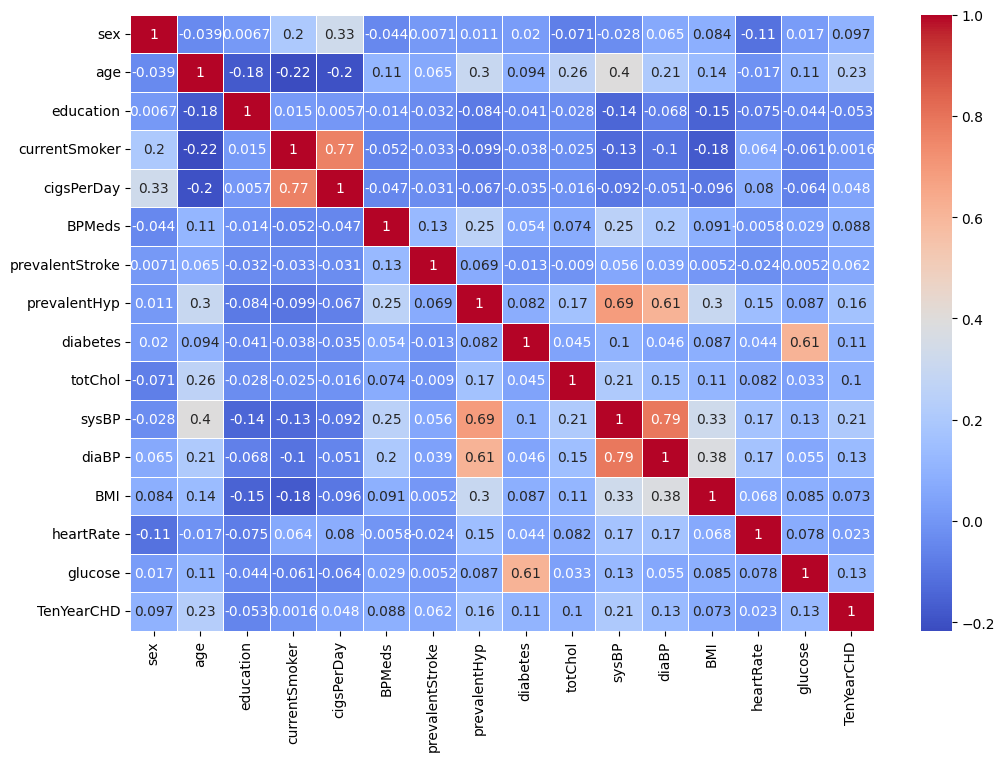

In [22]:
corr = train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()

Using the correlation matrix, we can determine how to go about handling the nan values. From the correlation matrix, we see that:

*education*: This variable had some missing values. It doesn't have a strong correlation with any other variable, so using the median is an appropriate choice for categorical data.

*cigsPerDay*: Also had missing values, but since it's highly correlated with currentSmoker, we will use a more nuanced approach for imputation. For current smokers (currentSmoker == 1), we could impute missing cigsPerDay with the median of cigsPerDay for all current smokers. For non-smokers (currentSmoker == 0), it's reasonable to impute any missing cigsPerDay with 0.

*BPMeds*: There were missing values in this variable as well. It has a slight positive correlation with prevalentHyp and sysBP. But, we will use proportional imputation.

*totChol*, *BMI*: These variables had missing values, and they show some correlations with other variables like age, sysBP, diaBP, etc. For these continuous variables, we could use multiple imputation techniques or predict missing values based on a regression model that includes correlated predictors. However, since these correlations are not very strong, the median imputation we initially used is a robust and straightforward approach.

*glucose*: Also had missing values, but since it's highly correlated with diabetes, we will use a more nuanced approach for imputation. For glucose == 1, we could impute missing glucose with the mean of diabetics. For non-glucose (glucose == 0), it's reasonable to impute any missing glucose with mean of non-diabetics.

In [26]:
median_cigs_smokers = train_data[train_data['currentSmoker'] == 1]['cigsPerDay'].median()

# Impute missing cigsPerDay values for current smokers with the median and for non-smokers with 0
train_data.loc[(train_data['currentSmoker'] == 1) & (train_data['cigsPerDay'].isnull()), 'cigsPerDay'] = median_cigs_smokers
train_data.loc[(train_data['currentSmoker'] == 0) & (train_data['cigsPerDay'].isnull()), 'cigsPerDay'] = 0

# Verify the imputation
train_data.isnull().sum()

sex                  0
age                  0
education           85
currentSmoker        0
cigsPerDay           0
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             39
sysBP                0
diaBP                0
BMI                 15
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64

In [27]:
education_train = train_data['education'].median()

#Fill with median
train_data['education'].fillna(education_train, inplace=True)

#Verify
train_data.isnull().sum()

sex                  0
age                  0
education            0
currentSmoker        0
cigsPerDay           0
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             39
sysBP                0
diaBP                0
BMI                 15
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64

In [28]:
totChol_train = train_data['totChol'].median()

#Fill with median
train_data['totChol'].fillna(totChol_train, inplace=True)

#Verify
train_data.isnull().sum()

sex                  0
age                  0
education            0
currentSmoker        0
cigsPerDay           0
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                 15
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64

In [29]:
bmi_train = train_data['BMI'].median()

#Fill with median
train_data['BMI'].fillna(bmi_train, inplace=True)

#Verify
train_data.isnull().sum()

sex                  0
age                  0
education            0
currentSmoker        0
cigsPerDay           0
BPMeds              37
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol              0
sysBP                0
diaBP                0
BMI                  0
heartRate            0
glucose            285
TenYearCHD           0
dtype: int64

In [31]:
# Calculate the mean glucose level for diabetic patients
mean_glucose_diabetic = train_data[train_data['diabetes'] == 1]['glucose'].mean()

# Calculate the mean glucose level for non-diabetic patients
mean_glucose_non_diabetic = train_data[train_data['diabetes'] == 0]['glucose'].mean()

# Function to apply the imputation logic
def impute_glucose(row):
    if pd.isnull(row['glucose']):
        return mean_glucose_diabetic if row['diabetes'] == 1 else mean_glucose_non_diabetic
    else:
        return row['glucose']

# Apply the function to the glucose column
train_data['glucose'] = train_data.apply(impute_glucose, axis=1)

#Verify
train_data.isnull().sum()

sex                 0
age                 0
education           0
currentSmoker       0
cigsPerDay          0
BPMeds             37
prevalentStroke     0
prevalentHyp        0
diabetes            0
totChol             0
sysBP               0
diaBP               0
BMI                 0
heartRate           0
glucose             0
TenYearCHD          0
dtype: int64

In [32]:
# Calculate the proportion of '1's in the BPMeds column of the original training data
bpmeds_proportion = train_data['BPMeds'].mean()

bpmeds_proportion

0.02958956411072224

The proportion of 1's seems to be about 3% in the train data

In [36]:
# Calculate how many of the missing values should be assigned a '1' based on the proportion
num_ones_to_assign = int(np.round(bpmeds_proportion * 37))

# Create an array of zeros for imputation
imputed_bpmeds = np.zeros(37)

# Assign '1's based on the calculated number
imputed_bpmeds[:num_ones_to_assign] = 1

imputed_bpmeds


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

So, we will assign 1 NA value to 1 and the rest to be 0

In [37]:
# Shuffle the array to randomly distribute the '1's
np.random.shuffle(imputed_bpmeds)

# Assign the imputed values back to the original dataframe (only for the missing values)
train_data.loc[train_data['BPMeds'].isnull(), 'BPMeds'] = imputed_bpmeds

#Verify
train_data.isnull().sum()

sex                0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [39]:
train_data.to_csv("train_cleaned.csv",index=False)

There are no more missing values to deal with in the train data.